In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

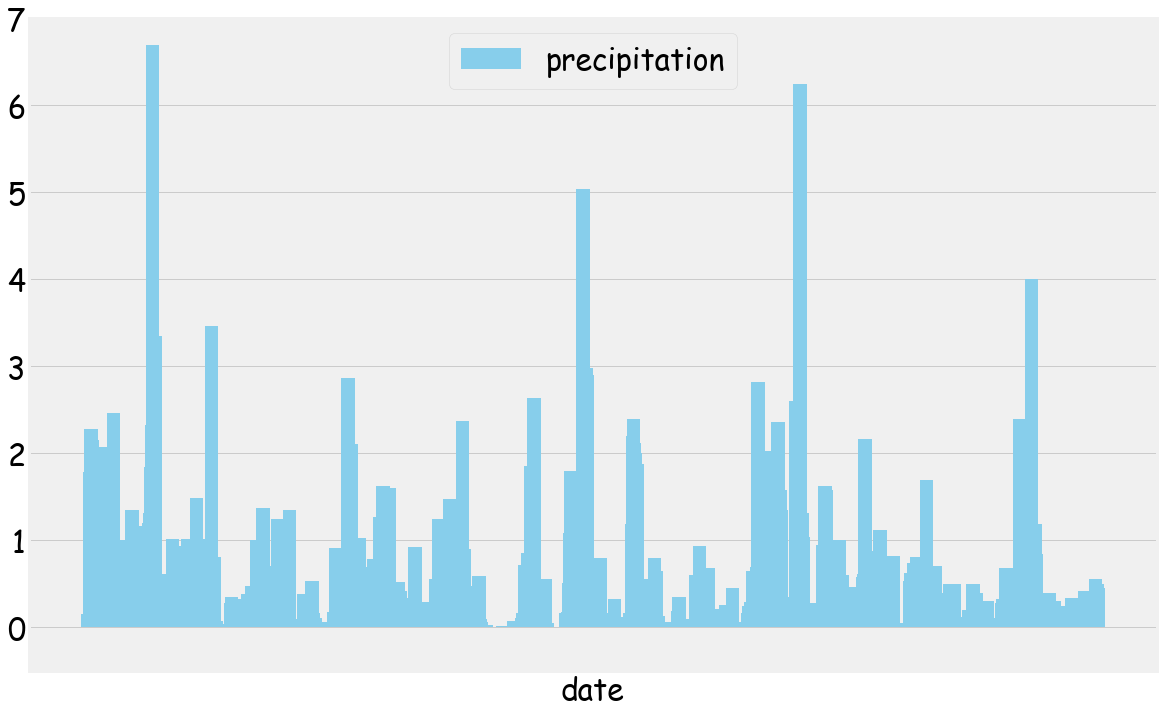

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
oneyearback=dt.datetime.strptime(lastdate[0], "%Y-%m-%d")-dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= oneyearback).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)

# Use Pandas Plotting with Matplotlib to plot the data
plt.rc('font',family='fantasy')
fig, ax = plt.subplots(figsize=(18,12))
Plot1 = ax.bar(df.index,df.prcp,30, color='SkyBlue',label='precipitation')

# Plot format
ax.set_xlabel('date',fontsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.set_ylim([-0.5, 7])
ax.set_xticks([])
ax.legend(loc='upper center',fontsize=30)



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count('*')).select_from(Station).scalar()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sta_max=stations[0][0]
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station==sta_max).all()

[(54.0, 85.0, 71.66378066378067)]

C:\Users\WenchaoWang\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


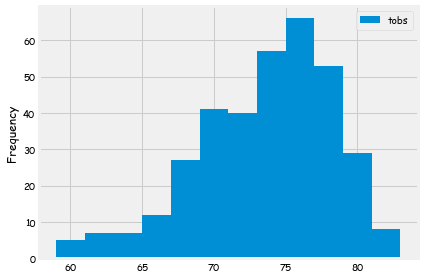

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_observation=session.query(Measurement.tobs).\
filter(Measurement.station==sta_max).\
filter(Measurement.date >= oneyearback).all()
dff = pd.DataFrame(results_observation)

# Plot
plt.rc('font',family='fantasy')
fig, ax = plt.subplots(sharey=True, tight_layout=True)

# Plot format
ax.hist(dff.tobs, bins=12,label='tobs')
ax.tick_params(axis='y')
ax.set_ylabel('Frequency')
ax.grid(True)
ax.legend(loc='upper right')


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Define trip start and end
trip_start='2017-05-25'
trip_end='2017-05-30'

# Calculate the trip temps info to plot
trip_temp=calc_temps(trip_start, trip_end)[0]
trip_temp

(69.0, 75.3529411764706, 82.0)

<function matplotlib.pyplot.show(*args, **kw)>

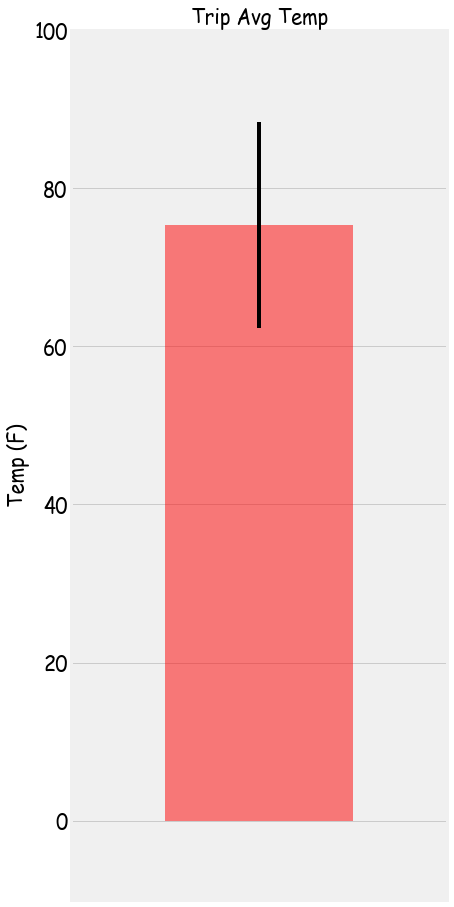

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Plot
plt.rc('font',family='fantasy')
fig, ax = plt.subplots(figsize=(6,16))
# Plot Format
ax.bar(0,trip_temp[1], 2, yerr=trip_temp[2]-trip_temp[0],color='red',alpha =0.5)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel('Temp (F)',fontsize=20)
ax.grid(True)
ax.set_xticks([])
ax.set_ylim([-10, 100])
ax.set_xlim([-2, 2])
ax.set_title('Trip Avg Temp',fontsize=20)
plt.show

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_precip(start_date, end_date):
    sel=[Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp)]
    return session.query(*sel).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Measurement.station == Station.station).\
        order_by(func.avg(Measurement.prcp).desc()).group_by(Measurement.station).all()

calc_precip(trip_start, trip_end)

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.345),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.30000000000000004),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.11),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.088),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.021666666666666667)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
x=[]
y=dt.datetime.strptime(trip_start, "%Y-%m-%d")
for i in range(6):
    x.append(y.strftime("%m-%d"))
    y=y+dt.timedelta(days=1)
normal=[]
for i in x:
    normal.append(daily_normals(i)[0])
normal

[(68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_date=[]
loopdate=dt.datetime.strptime(trip_start, "%Y-%m-%d")
for i in range(6):
    trip_date.append(loopdate.strftime("%Y-%m-%d"))
    loopdate=loopdate+dt.timedelta(days=1)

dfff = pd.DataFrame(normal,columns=['temp_min','temp_avg','temp_max'])
dfff['date']=trip_date
dfff.set_index('date')

,temp_min,temp_avg,temp_max
date,,,
2017-05-25,68.0,74.275862,79.0
2017-05-26,65.0,74.036364,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0


[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80')]

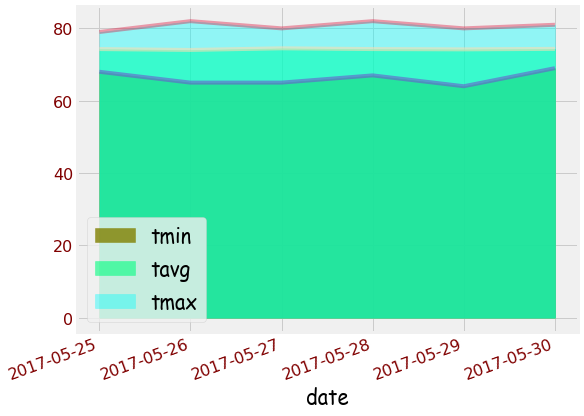

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
# I cannot find area plot in matplotlib, which leads to the below plot. Create the pandas one below

plt.rc('font',family='fantasy')
fig, ax = plt.subplots(figsize=(8,6))
font = {'family': 'DejaVu Sans',
        'color':  'maroon',
        'weight': 'normal',
        'size': 16,
        }
ax.fill_between( dfff.date, dfff.temp_min, color="olive", alpha=0.8, label='tmin')
ax.plot(dfff.date, dfff.temp_min, color="Slateblue", alpha=0.6, label='_nolegend_')
ax.fill_between( dfff.date, dfff.temp_avg, color="springgreen", alpha=0.6, label='tavg')
ax.plot(dfff.date, dfff.temp_avg, color="wheat", alpha=0.6, label='_nolegend_')
ax.fill_between( dfff.date, dfff.temp_max, color="aqua", alpha=0.4, label='tmax')
ax.plot(dfff.date, dfff.temp_max, color="crimson", alpha=0.4, label='_nolegend_')
ax.set_xlabel('date',fontsize=20)
ax.grid(True)
ax.legend(loc='lower left',fontsize=20)
ax.set_xticklabels(dfff.date, rotation=20, ha='right',fontsize=20,fontdict=font)
ax.set_yticklabels([0,0,20,40,60,80], rotation=0, ha='right',fontsize=20,fontdict=font)

,temp_min,temp_avg,temp_max
date,,,
2017-05-25,68.0,74.275862,79.0
2017-05-26,65.0,74.036364,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0


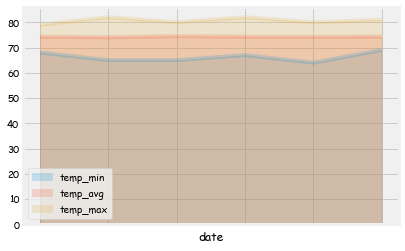

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
dffff=dfff.set_index('date')
dffff.plot.area(stacked=False,alpha=0.2)
plt.xticks(rotation=45, ha='right')
plt.show
dffff